In [5]:
import sys
sys.path.append("./../")

In [6]:
## %load ./../rnn_model.py
#!/usr/bin/env python
'''
 Import necessary packages

'''
import tensorflow as tf
# set hardware config
#tf.debugging.set_log_device_placement(True)

cpus = tf.config.experimental.list_physical_devices(device_type='CPU')
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')

# set gpu memory grouth automatically
#for gpu in gpus:
#    tf.config.experimental.set_memory_growth(gpu, True)

if(gpus!=[]):
    # set virtal gpu/ logical gpu, create four logical gpu from a physical gpu (gpus[0])
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3072),
        tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3072),
        tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3072),
        tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3072)
        ]
        )

logical_cpus = tf.config.experimental.list_logical_devices(device_type='CPU')
logical_gpus = tf.config.experimental.list_logical_devices(device_type='GPU')
print('physical cpus and gpus: ',cpus, gpus)
print('physical cpus number: ', len(cpus))
print('physical cpgs number: ', len(gpus))
print('logical cpus and gpus: ',logical_cpus, logical_gpus)
print('logical cpgs number: ', len(logical_gpus))

print("tensorflow version:",tf.__version__)


import numpy as np
import matplotlib.pyplot as plt
import pdb
import os
import pandas as pd
import yaml
import h5py
import vicon_imu_data_process.process_rawdata as pro_rd
import estimation_assessment.scores as es_as
import estimation_assessment.visualization as es_vl

import seaborn as sns
import copy
import re
import json

from vicon_imu_data_process.const import FEATURES_FIELDS, LABELS_FIELDS, DATA_PATH, TRAIN_USED_TRIALS
from vicon_imu_data_process.const import DROPLANDING_PERIOD, RESULTS_PATH
from vicon_imu_data_process import const
from vicon_imu_data_process.dataset import *

from estimation_models.rnn_models import *
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
import time as localtimepkg

from estimation_study import *


physical cpus and gpus:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')] []
physical cpus number:  1
physical cpgs number:  0
logical cpus and gpus:  [LogicalDevice(name='/device:CPU:0', device_type='CPU')] []
logical cpgs number:  0
tensorflow version: 2.5.0
tensorflow version: 2.5.0
tensorflow version: 2.5.0
[LogicalDevice(name='/device:CPU:0', device_type='CPU')] []


-----------------------------------------------------------
# Training results analysis


## Load training folder

## training data folder

In [33]:

# 45 lstm units with all sensor configs
#combination_investigation_results = "/media/sun/DATA/Drop_landing_workspace/suntao/Results/Experiment_results/investigation/2022-04-27/204501/testing_result_folders.txt"

# several sensor config and various lstm units
#combination_investigation_results = "/media/sun/DATA/Drop_landing_workspace/suntao/Results/Experiment_results/investigation/2022-04-27/143322/testing_result_folders.txt"

# all sensor config and 35 lstm units
combination_investigation_results = "/media/sun/DATA/Drop_landing_workspace/suntao/Results/Experiment_results/investigation/2022-04-30/all_sensor_list/testing_result_folders.txt"
combination_investigation_results = "/media/sun/DATA/Drop_landing_workspace/suntao/Results/Experiment_results/investigation/2022-05-06/150524/testing_result_folders.txt"
combination_investigation_results = "/media/sun/DATA/Drop_landing_workspace/suntao/Results/Experiment_results/investigation/2022-05-06/153846/off_on_synchronizationtesting_result_folders.txt"
combination_investigation_results = "/media/sun/DATA/Drop_landing_workspace/suntao/Results/Experiment_results/investigation/2022-05-09/094720/off_on_synchronizationtesting_result_folders.txt"
print(combination_investigation_results)

/media/sun/DATA/Drop_landing_workspace/suntao/Results/Experiment_results/investigation/2022-05-09/094720/off_on_synchronizationtesting_result_folders.txt


In [43]:
# combination investigation results
#combination_investigation_results = "/media/sun/DATA/Drop_landing_workspace/suntao/Results/Experiment_results/investigation/2022-04-18/140739/testing_result_folders.txt"

from estimation_assessment.visualization import *
#import pdb
import re

def get_investigation_config(number)
    fd = open(combination_investigation_results,'r')
    lines = fd.readlines()
    
    line =lines[0] # 第一行
    single_investigation_config_names = line.split('\t')
    line =lines[number] # 最后一行
    single_investigation_config = line.split('\t')
    
    testing_folder = single_investigation_config[-1]
    print('investigation configuration: {}'.format(single_investigation_config[:-1]))
    fd.close()
    training_folder = re.search(r'.*-[\d]{2}/', testing_folder).group(0) + '/training'+ re.search(r'_(\d){6}',testing_folder).group(0)
    


investigation configuration: ['FSTWC', '35', 'False', 'single_leg_R', "['L_KNEE_MOMENT_X']"]


"\n[sensor_config, model_size, testing_folder] = line.split('\t')\ntesting_folder = testing_folder.strip('\n')\nprint('sensor configuration: {}, lstm unit: {}'.format(sensor_config, model_size))\nfd.close()\n"

## Plot history

/media/sun/DATA/Drop_landing_workspace/suntao/Results/Experiment_results/training_testing/2022-05-09//training_094439/train_process/my_history
dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])
Max train and validtion MAE: 0.3146 and 0.5458


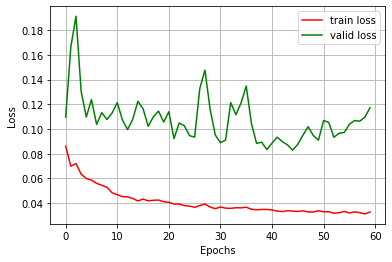

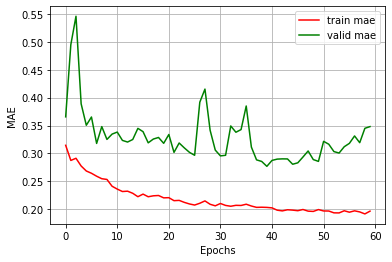

In [45]:
history_file = training_folder + '/train_process/my_history'
print(history_file)

#history_file = os.path.join(RESULTS_PATH, "training_testing_results/2022-04-14/training_220632/train_process/my_history")
history = json.load(open(history_file, 'r'))
plot_history(history)

FileNotFoundError: [Errno 2] No such file or directory: '/media/sun/DATA/Drop_landing_workspace/suntao/Results/Experiment_results/training_testing/2022-05-09/test_094439/test_1\n/10_03_27.svg'

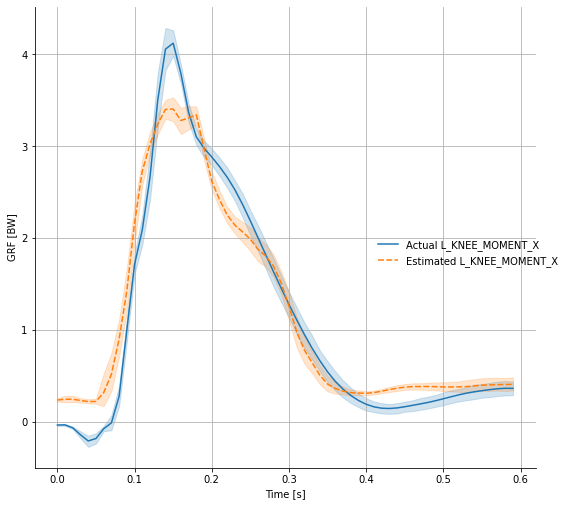

In [46]:
plot_statistic_actual_estimation_curves(training_folder,testing_folder,verbose=1)

## Plot estimation value

subject: P_08_zhangboyuan and trial: 01
model input:  (60, 31)
model prediction:  (60, 1)
Estimation metrics: (r2, mae, rmse, r_rmse)  (0.839, 0.506, 0.363, 0.12)


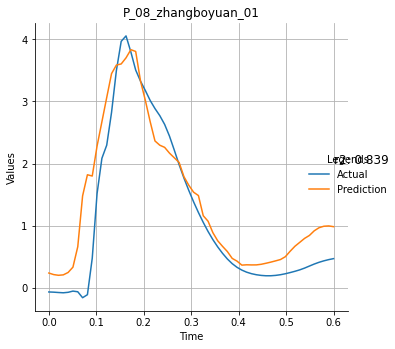

In [47]:

# load hyper parameters
fd = open(training_folder+'/hyperparams.yaml','r')
hyperparams = yaml.load(fd, Loader=yaml.Loader)
fd.close()

# load trianed model with best parameters
trained_model = load_trained_model(training_folder)

# create testing folder
testing_folder = pro_rd.create_testing_files(training_folder)


# -------------- dataset------
subjects_trials_data, norm_subjects_trials_data, scaler = load_normalize_data(hyperparams, syn_features_labels=True)
subject_id_name = hyperparams['test_subject_ids_names'][0]
#subject_id_name = 'P_23_wangjinhong'

trial = '01'
print("subject: {} and trial: {}".format(subject_id_name, trial))

xy_test = norm_subjects_trials_data[subject_id_name][trial]

# ----------------- estimation
print("model input: ", xy_test.shape)
model_prediction = model_forecast(trained_model, xy_test, hyperparams)
print("model prediction: ", model_prediction.shape)

# reshape and inverse normalization
prediction_xy_test = copy.deepcopy(xy_test) # deep copy of test data
prediction_xy_test[:,-int(hyperparams['labels_num']):] = model_prediction # using same shape with all datasets

predictions = scaler.inverse_transform(prediction_xy_test)[:, -int(hyperparams['labels_num']):] # inversed norm predition
labels  = scaler.inverse_transform(xy_test)[:, -int(hyperparams['labels_num']):]
#features = scaler.inverse_transform(xy_test)[:,:-int(hyperparams['labels_num'])]


#---------------- shift predictions
shift_estimation = False
if shift_estimation:
    dim = predictions.shape
    print("predictions dim:",dim)

    prefix = np.array([0,0,0])
    pre_temp = np.insert(predictions,0, prefix).reshape(-1,1)

    print("pre temp dim:", pre_temp.shape)
    pre_temp = 1.25*pre_temp[:dim[0],:]
    print("pre temp dim:", pre_temp.shape)
    
    pre_metrics =  calculate_scores(labels, pre_temp)
    print("Shifted estimation metrics: (r2, mae, rmse, r_rmse) ",pre_metrics)
    pd_predictions = pd.DataFrame(pre_temp, columns=hyperparams['labels_names'])


# ----------- Print  scores of the estimation
metrics = calculate_scores(labels,predictions)
print("Estimation metrics: (r2, mae, rmse, r_rmse) ", metrics)

# ----------- Transfer labels and predictions into dadaframe
pd_labels = pd.DataFrame(labels, columns=hyperparams['labels_names'])
if not shift_estimation:
    pd_predictions = pd.DataFrame(predictions, columns=hyperparams['labels_names'])
else:
    metrics = pre_metrics


# -----------Plot results
plot_actual_estimation_curves(pd_labels, pd_predictions, testing_folder=testing_folder, figtitle=subject_id_name + '_' + trial, metrics='r2: ' + str(metrics[0]),verbose=1)


In [ ]:
pd_assessment = get_testing_metrics(combination_investigation_results)

In [ ]:
x = pd_assessment[pd_assessment['metrics']=='r2']
print(x.head())
print(pd_assessment.shape)
#sns.catplot(data=x, x= 'Model size', y='scores', col = 'Sensor configuration', col_wrap=4, sharey=True,kind='point')
g = sns.catplot(data=x, y='scores', x= 'Sensor configuration',kind='point')

g.ax.set_xlabel('Sensor configuration')
g.ax.set_ylabel('R2')
g.fig.set_figwidth(18)
g.ax.grid(axis='both',which='major')


In [ ]:
from estimation_assessment.visualization import *
#combination_investigation_results = "/media/sun/My Passport/DropLanding_workspace/suntao/Results/Experimental_Results/combination_investigation_results/2022-04-09/200611/testing_result_folders.txt"
#combination_investigation_results = "/media/sun/My Passport/DropLanding_workspace/suntao/Results/Experimental_Results/combination_investigation_results/2022-04-12/170711/testing_result_folders.txt"
#combination_investigation_results = os.path.join(RESULTS_PATH,"combination_investigation_results/2022-04-12/153004/testing_result_folders.txt")
plot_combination_investigation_results(combination_investigation_results,'Model size')
#training_folder = "/media/sun/My Passport/DropLanding_workspace/suntao/Results/Experimental_Results/models_parameters_results/2022-04-08/training_200647"
#check_model_test(training_folder)

### Investigation of the influence of \bt{sensor configurations} on GRF estimation performance

In [ ]:
pd_assessment = evaluate_models_on_unseen_subject(combination_investigation_results, saved_file_name_prefix='all_sensor_config_')

In [ ]:
pd_assessment = plot_model_evaluation_on_unseen_subject(pd_assessmentation_investigation_results,
                                                        investigation_variable='Sensor configurations',
                                                        displayed_metrics=['r2','r_rmse']
                                                        )

### Investigation of the influence of \bt{model size} on GRF estimation performance

In [ ]:
pd_assessment = plot_model_evaluation_on_unseen_subject(pd_ass,
                                                        investigation_variable='Model size',
                                                        displayed_metrics = ['r2','r_rmse']
                                                       )

## exit machine and save environment

In [ ]:
os.system("export $(cat /proc/1/environ |tr '\\0' '\\n' | grep MATCLOUD_CANCELTOKEN)&&/public/script/matncli node cancel -url https://matpool.com/api/public/node -save -name suntao_env")